In [1]:
!pip install umap-learn
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=5ddde103cbc33c034de8b49ae3359d3f3306d9bc18cba8fb83819ffb780eecf1
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=48780add48619472cbac80c4087c44370efe22a462cbf06c9eb50a8d2e6d6a57
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/pu

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, adjusted_rand_score, rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD

import umap
import hdbscan

# Flowers Dataset and VGG Features

In [3]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:42<00:00,  1.36it/s]


In [4]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


In [5]:
#confirming original image size
dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
for i, (x,y) in enumerate(dataset):
    if i < 2:
      print(x.shape)
      print(y)
    else:
      break

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
0


In [6]:
#observe this is not a sparse matrix
print(np.count_nonzero(f_all)/4096) #this matches original sample size
print(f_all[99]) #values shown are not close to zero

3670.0
[-2.14356947 -0.83152497  0.14578724 ... -2.21262312 -3.53307223
 -0.96075946]


In [7]:
#t-SNE
f_tsne = TSNE(n_components=2).fit_transform(f_all)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 't-SNE Plot')

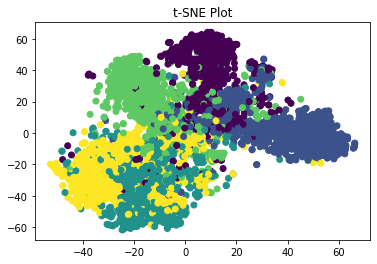

In [8]:
plt.scatter(*f_tsne.T, c=y_all)
plt.title("t-SNE Plot")

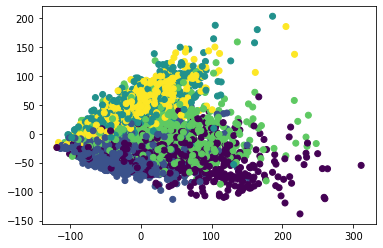

In [9]:
f_pca = PCA(n_components=2).fit_transform(f_all)
plt.scatter(*f_pca.T, c=y_all)

# MLP Classifier

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                # you should implement this part #
                ##################################
                raise NotImplementedError
        return self
    
    def eval(self, X_test, y_test):
        ##################################
        # you should implement this part #
        ##################################
        raise NotImplementedError

# Autoencoder

In [11]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


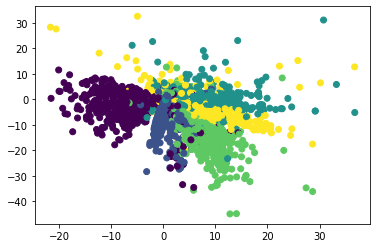

In [12]:
X_em =Autoencoder(2).fit_transform(f_all)
plt.scatter(*X_em.T, c=y_all)

In [13]:
#Results for Grid Search

res = {}


In [14]:
#get the options for the reduced dataset
f_reduced = {}
f_reduced['None'] = f_all
f_reduced['SVD'] = TruncatedSVD(n_components=50).fit_transform(f_all)
f_reduced['UMAP'] = umap.UMAP(n_components=50).fit_transform(f_all)
f_reduced['Autoencoder'] = Autoencoder(50).fit_transform(f_all)

100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


In [15]:
clusteringOptions = {
    'K-Means': KMeans(n_clusters=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=5),
    'HDBSCAN': None,
}

In [16]:
#get the results for the not HDBSCAN options
for key in clusteringOptions.keys():
    if key != 'HDBSCAN':
      for key2 in f_reduced.keys():
        newKey = key2 + ' and ' + key
        print(newKey)
        res[newKey] = clusteringOptions[key].fit_predict(f_reduced[key2])

None and K-Means
SVD and K-Means
UMAP and K-Means
Autoencoder and K-Means
None and Agglomerative Clustering
SVD and Agglomerative Clustering
UMAP and Agglomerative Clustering
Autoencoder and Agglomerative Clustering


In [17]:
#get the results of the minimal grid search for HDBSCAN
min_cluster_sizes = [ 5, 50, 500 ]
min_samples = [ 5, 50, 500 ]

for key2 in f_reduced.keys():
  for clusterSize in min_cluster_sizes:
    for minSample in min_samples:
      newKey = key2 + ' and HDBSCAN with min cluster size ' + str(clusterSize) + ' and min samples ' + str(minSample)
      print(newKey)
      res[newKey] = hdbscan.HDBSCAN(min_cluster_size=clusterSize, min_samples=minSample).fit_predict(f_reduced[key2])



None and HDBSCAN with min cluster size 5 and min samples 5
None and HDBSCAN with min cluster size 5 and min samples 50
None and HDBSCAN with min cluster size 5 and min samples 500
None and HDBSCAN with min cluster size 50 and min samples 5
None and HDBSCAN with min cluster size 50 and min samples 50
None and HDBSCAN with min cluster size 50 and min samples 500
None and HDBSCAN with min cluster size 500 and min samples 5
None and HDBSCAN with min cluster size 500 and min samples 50
None and HDBSCAN with min cluster size 500 and min samples 500
SVD and HDBSCAN with min cluster size 5 and min samples 5
SVD and HDBSCAN with min cluster size 5 and min samples 50
SVD and HDBSCAN with min cluster size 5 and min samples 500
SVD and HDBSCAN with min cluster size 50 and min samples 5
SVD and HDBSCAN with min cluster size 50 and min samples 50
SVD and HDBSCAN with min cluster size 50 and min samples 500
SVD and HDBSCAN with min cluster size 500 and min samples 5
SVD and HDBSCAN with min cluster s

In [18]:
scores = {}

for key in res.keys():
  scores[key] = adjusted_rand_score( y_all, res[key])

In [19]:
print(scores)

{'None and K-Means': 0.18967319657025597, 'SVD and K-Means': 0.19593913524301027, 'UMAP and K-Means': 0.42012366542030477, 'Autoencoder and K-Means': 0.20548713369005908, 'None and Agglomerative Clustering': 0.18855278251971858, 'SVD and Agglomerative Clustering': 0.21615545991943408, 'UMAP and Agglomerative Clustering': 0.3700057451490448, 'Autoencoder and Agglomerative Clustering': 0.25684572572482056, 'None and HDBSCAN with min cluster size 5 and min samples 5': 0.006705947729476718, 'None and HDBSCAN with min cluster size 5 and min samples 50': 0.0, 'None and HDBSCAN with min cluster size 5 and min samples 500': 0.0, 'None and HDBSCAN with min cluster size 50 and min samples 5': 0.0, 'None and HDBSCAN with min cluster size 50 and min samples 50': 0.0, 'None and HDBSCAN with min cluster size 50 and min samples 500': 0.0, 'None and HDBSCAN with min cluster size 500 and min samples 5': 0.0, 'None and HDBSCAN with min cluster size 500 and min samples 50': 0.0, 'None and HDBSCAN with mi

In [20]:
#need to know the top of this for Q25
for k, v in sorted( ((v,k) for k,v in scores.items()), reverse=True):
  print(k, v)

0.42012366542030477 UMAP and K-Means
0.3700057451490448 UMAP and Agglomerative Clustering
0.2840727935592511 UMAP and HDBSCAN with min cluster size 500 and min samples 5
0.279309901456811 UMAP and HDBSCAN with min cluster size 50 and min samples 5
0.25684572572482056 Autoencoder and Agglomerative Clustering
0.25655077252396474 UMAP and HDBSCAN with min cluster size 500 and min samples 50
0.252324673677063 UMAP and HDBSCAN with min cluster size 5 and min samples 5
0.23601556293263562 UMAP and HDBSCAN with min cluster size 50 and min samples 50
0.22777899774535743 UMAP and HDBSCAN with min cluster size 5 and min samples 50
0.21615545991943408 SVD and Agglomerative Clustering
0.20548713369005908 Autoencoder and K-Means
0.19593913524301027 SVD and K-Means
0.18967319657025597 None and K-Means
0.18855278251971858 None and Agglomerative Clustering
0.12479684675291036 UMAP and HDBSCAN with min cluster size 50 and min samples 500
0.09432485481809882 UMAP and HDBSCAN with min cluster size 5 and 